# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [398]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import tweepy  # you will need to install tweepy first
# We want to visualize the network we create, to do so we will use networkx
import networkx as nx # WARNING: Library not included in the standard notebook

In [174]:
# Variable used to print degug information in this notebook
DEBUG_INFO = True

In [424]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [425]:
user = 'msf'
user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [426]:
def find_connections(user_id,nbr_of_pages=1):
    followers = []
    friends=[]
    try:
        for part_friends in tweepy.Cursor(api.friends_ids, id=user_id).pages(nbr_of_pages):
            friends.extend(part_friends)
        for part_followers in tweepy.Cursor(api.followers_ids, id=user_id).pages(nbr_of_pages):
            followers.extend(part_followers)
    except tweepy.TweepError as e:
        # Manage errors from the tweepy API. We simply print the error information
        print("Error while finding connections!\n\tReason:",
              "{}\n\tResponse: {}\n\tAPI Code: {}".format(e.reason, e.response, e.api_code))
        return None
    else:
        connections = np.intersect1d(friends, followers)
        # Print some debug information related to the s
        if DEBUG_INFO:
            print("{} has {} connections from {} friends and {} followers when using {} pages".format(
                user_id, len(connections), len(friends), len(followers), nbr_of_pages)
                 )
        return connections

In [427]:
# Change the value of nbr_of_pages to obtain more friends_ids and followers_ids
# Warning : If the page number is too high, we will run into rate limitation!
nbr_of_pages=2
first_connections=find_connections(user_id,nbr_of_pages)
print('{}has {} connections'.format(user, len(first_connections)))

2195671183 has 9 connections from 1215 friends and 10000 followers when using 2 pages
msfhas 9 connections


In [428]:
print(first_connections)

[          26786894          105862849          227459248
          391380430          602646287         2535776912
 784351656355897344 875658499186929664 904725709377167360]


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [429]:
network={}
first_nodes=[]
second_nodes=[]
how_many=2 #This is the number of connections you are sampling. 
           #Keep small (e.g.3) for development, larger later (e.g. 10)
first_nodes=np.random.choice(first_connections, size=how_many,replace=False)

**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [430]:
network[user_id] = first_nodes

In [431]:
pprint(network)

{2195671183: array([  26786894, 2535776912])}


Lets find the connections of the second nodes

In [432]:
# Loop over the nodes that are linked to the user_id
# The goal is to find second nodes for each of those nodes
# And to populate both the second_nodes array and the network dict
for node in first_nodes:
    # try/except/else for the case where the argument to np.random.choice is bad.
    # It happens when the node doesn't allow us to check for its connections
    try:
        found_connections = np.random.choice(find_connections(node,nbr_of_pages), size=how_many, replace=False)
    except:
        print("The connections for node {} could not be gathered".format(node))
    else:
        second_nodes.extend(found_connections)
        # Add the source node and the connections nodes
        network[node] = np.append(found_connections, user_id) 

Rate limit reached. Sleeping for: 25
26786894 has 424 connections from 709 friends and 7188 followers when using 2 pages
2535776912 has 20 connections from 73 friends and 186 followers when using 2 pages


In [433]:
all_nodes=np.concatenate((first_nodes, second_nodes))
print(all_nodes)

[          26786894         2535776912          616271489
 821794140375699457          499107662           34388075]


In [434]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 2 first hop nodes
There are 4 second hop nodes
There are overall 6 nodes in the collected network


In [435]:
for i in second_nodes:
    network[i]=[]

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [436]:
if DEBUG_INFO:
    # Lets test how show friendship works, by comparing an element of first nodes
    # with user_id
    source, target = api.show_friendship(source_id=np.random.choice(first_nodes, 1)[0],target_id=user_id)

    # Lets see what the result looks like
    print(source,"\n", target)
    
    # We see that we have the info if the source is following and
    # if it is followed by the target. If we "and" those information
    # we can test if there's a connection
    print(source.following)
    print(source.followed_by)

Friendship(_api=<tweepy.api.API object at 0x7fb05e326390>, id=2535776912, id_str='2535776912', screen_name='MSF_imprensa', following=True, followed_by=True, live_following=False, following_received=None, following_requested=None, notifications_enabled=None, can_dm=True, blocking=None, blocked_by=None, muting=None, want_retweets=None, all_replies=None, marked_spam=None) 
 Friendship(_api=<tweepy.api.API object at 0x7fb05e326390>, id=2195671183, id_str='2195671183', screen_name='MSF', following=True, followed_by=True, following_received=None, following_requested=None)
True
True


In [437]:
def should_add_node_as_connection(source, target,network):
    """This function take a source node and a target node and says if they are connections
        It assumes the dictionnary "network" has been declared in the environment
    """
    # Check for trivial cases 
    # 1) it is source
    if target == source:
        return False
    # 2) it is not a connection of source
    elif target in network[source]:
        return False
    # Check if we already have the required information
    elif source in network[target]:
        return True
    # Otherwise use the twitter API
    else:
        friendship_info = api.show_friendship(source_id=node, target_id=target)[0]
        if friendship_info.following and friendship_info.followed_by:
            return True
        else:
            return False

In [438]:
pprint(network)

{26786894: array([         616271489, 821794140375699457,         2195671183]),
 34388075: [],
 499107662: [],
 616271489: [],
 2195671183: array([  26786894, 2535776912]),
 2535776912: array([ 499107662,   34388075, 2195671183]),
 821794140375699457: []}


In [439]:
# Source node for connection comparison
for node in all_nodes:
    nodes_to_add = [target for target in all_nodes if should_add_node_as_connection(node, target,network)]
    network[node] = np.union1d(network[node], nodes_to_add)

In [440]:
pprint(network)

{26786894: array([  6.16271489e+08,   2.19567118e+09,   8.21794140e+17]),
 34388075: array([  2.53577691e+09]),
 499107662: array([  2.53577691e+09]),
 616271489: array([ 26786894.]),
 2195671183: array([  26786894, 2535776912]),
 2535776912: array([  3.43880750e+07,   4.99107662e+08,   2.19567118e+09]),
 821794140375699457: array([ 26786894.])}


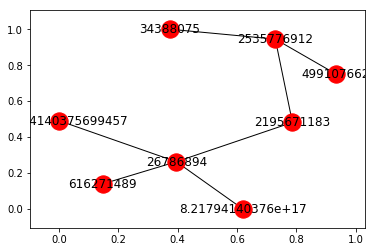

In [441]:
# Visualize the graph
network_graph = nx.Graph(network)
nx.draw_networkx(network_graph)

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [442]:
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [443]:
for row in range(0,len(all_nodes)):
    for col in range(0,len(all_nodes)):
         # A node cannot be adjacent to itself
        if row is col:    
            W[row][col] = 0
        #Check if there's an edge connectiong the nodes
        elif (all_nodes[row] in network[all_nodes[col]]) or (all_nodes[col] in network[all_nodes[row]]):
            W[row][col] = 1
        else:
            W[row][col] = 0

Remember that a weight matrix should be symmetric. Check if it is:

In [444]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:** If could have happened in the cases where a user doesn't let us check its contacts if we programmed differently. Indeed, if we used only the entry in the dictionary "network" associated with the node to populate the array, if the entry wouldn't contain a connection that is in the dictionary associated the other node, then there could be mismatch. Because we use both the dictionary entry for the node and the dictionary entry of its potential connection in the edge boolean detector, this case cannot happen.

Impose your weight matrix to be symmetric.

In [445]:
# Make W is symmetric
bigger = W.transpose() > W

In [446]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

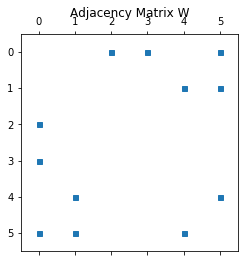

In [396]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W,markersize=5)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
* Maximum number of links : the maximum number of links is attained when every node is connected to every other node. It is given by:
$$ L_{max} = (N*N-1) / 2$$
N-1 used to remove the diagonal from the count

In [241]:
Lmax=len(W)*(len(W)-1) /2
print(Lmax)

15.0


* How many links in collected network
We simply have to make the sum of the links in the network and divide it by two 
$$ L_W = \frac{1}{2} \sum_{i=0}^{len(W)-1}\sum_{j=0}^{len(W[0])-1}W(i)(j)$$

In [244]:
LW = np.sum(W)/2
print("Tere are {} links in the collected network".format(LW))

Tere are 6.0 links in the collected network


* Comment on how L and Lmax compare
<span class="burk">TODO: Do this once we have the complete dataset</span>

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [379]:
p = [np.sum(W[index]) for index in range(0, len(W))]

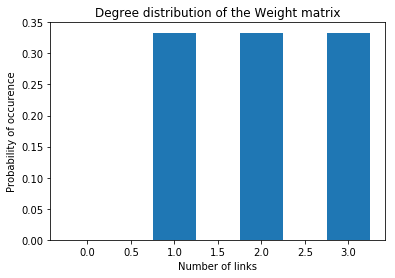

In [380]:
plt.hist(p, bins=range(0,np.amax(nbr_links)+2), normed=True, rwidth = 0.5, align='left')
plt.title("Degree distribution of the Weight matrix")
plt.xlabel("Number of links")
plt.ylabel("Probability of occurence")
plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:**
TODO: Answer once final data are obtained

## 2.3 Average degree

Calculate the average degree of your collected network.

In [382]:
d_avg = np.average(p)
print(d_avg)

2.0


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

Our graph originates with the twitter page of the "user_id" user, we will call the associated node "Source". Every nodes is added with a link to the Source node or with a link to a node that has a link to the Source node. Because of this, the longest path from any node to the source is 2. Even without seeing the actual graph, we can infer from this that the diameter of the network has an upper boundary of 4: any two pair of nodes that we will connect together have a maximum distance to the Source of 2 and therefore a maximum distance between them of 4.

<span class="burk">TODO: specific case once we have the final results(real diagram of network)</span>

**Your answer here:**

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [397]:
for row in W:
    if np.sum()
Wpruned = 1# your code here

[0 0 1 1 0 1]
[0 0 0 0 1 1]
[1 0 0 0 0 0]
[1 0 0 0 0 0]
[0 1 0 0 0 1]
[1 1 0 0 1 0]


In [ ]:
plt.spy(Wpruned, markersize=1)
plt.title('Adjacency Matrix W');